# Classification de textes Francais par entreprise

# Recuperation de donnée avec label

In [1]:
# imports
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
from copy import deepcopy
import ast
from scipy import stats

In [41]:
# fetching data
PATH = "./data/ArticleCompany_2020-11-17/"
coprus = "corpus_check_long_SIREN_UPDATED2"
names = "siren_name_map_clean"

with open(PATH + names +".json") as json_file: 
    dict_names = json.load(json_file) 

with open(PATH + coprus +".json") as json_file: 
    corpus_list = json.load(json_file) 

In [42]:
# Convert string to list of labels
print ("The siren list is:",type(corpus_list[0]["siren"]))
for document in corpus_list:
    document["siren"] = ast.literal_eval(document["siren"]) # convert list in string format to list
    for i in range(len(document["siren"])): # Convert each int siren to string 
        document["siren"][i] = str(document["siren"][i])
print ("NOW the type of the siren list is:",type(corpus_list[0]["siren"]))

The siren list is: <class 'str'>
NOW the type of the siren list is: <class 'list'>


# Remove articles with no text

In [43]:
corpus_list_inter = list()
for i in range(len(corpus_list)):
    if len(corpus_list[i]["corpus"])<100: # small enough
        text = corpus_list[i]["corpus"]
        text = re.sub("^(\s+)", '', text)
        if (len(text)>0):
            corpus_list_inter.append(corpus_list[i])
        else:
            print ("Index of removed article:",i,corpus_list[i]["corpus"])
    else:
        corpus_list_inter.append(corpus_list[i])
corpus_list = corpus_list_inter

Index of removed article: 29805   
Index of removed article: 30158     


In [44]:
print ("There are", len(corpus_list), "articles in the corpus")
print ("There are", len(dict_names), "companies in the list")

There are 57538 articles in the corpus
There are 30178 companies in the list


## Compter Nombre d'Entreprises sans Articles

In [45]:
dict_count = dict()
#for company in dict_names.keys(): dict_count[company] = 0
for document in corpus_list:
    sir_list = document["siren"]
    for siren in sir_list:
        if len(siren)>10: # Should not be triggered
            print ("ALERT:",siren)
        if siren in dict_count.keys():
            dict_count[siren] +=1
        else:
            dict_count[siren] = 1
print ("There are",len(dict_count.keys()),"companies with labels out of the", len(dict_names.keys()), "companies")
print ("there are",len(dict_names.keys())-len(dict_count.keys()),"companies with no articles")
print (round(len(dict_count)/(len(dict_names))*100,2),"% of the companies have articles")
print ("Each article of the corpus has:",corpus_list[0].keys())
#corpus_list[0]["corpus"]

There are 28690 companies with labels out of the 30178 companies
there are 1488 companies with no articles
95.07 % of the companies have articles
Each article of the corpus has: dict_keys(['id', 'siren', 'corpus', 'url_article'])


## Quels sont les entreprises sans articles?

In [46]:
dict_no_acticle_companies = dict()
for company in dict_names.keys():
    if company not in dict_count.keys():
        dict_no_acticle_companies[company] = dict_names[company] 

In [47]:
for key in dict_count.keys():
    if len(key)>10:
        print (key)

## Etude du nombre d'articles par entreprise

In [48]:
multiple_siren = 0
multiple_siren_list = list()
for document in corpus_list:
    if len(document["siren"])==0:
        print ("ALERT article sans tag, id:",document["id"])
    if len(document["siren"])>1:
        multiple_siren +=1
    multiple_siren_list.append(len(document["siren"]))
    
print(stats.describe(multiple_siren_list))   
print ("There are",multiple_siren,"arcticles with more that one tag out of the",len(corpus_list),"articles")        

DescribeResult(nobs=57538, minmax=(1, 29), mean=1.2476276547672842, variance=0.6042338178020358, skewness=8.133981486117998, kurtosis=136.56851777466036)
There are 9362 arcticles with more that one tag out of the 57538 articles


## Etudes du nombre d'articles associer a chaque entreprise 

In [49]:
# imports
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

DescribeResult(nobs=28690, minmax=(1, 175), mean=2.5021261763680727, variance=28.017371476985655, skewness=11.347634082651822, kurtosis=211.56847613512954)
There are 63.58 % articles with one associated article
There are 90.42 % articles with less than 5 associated article


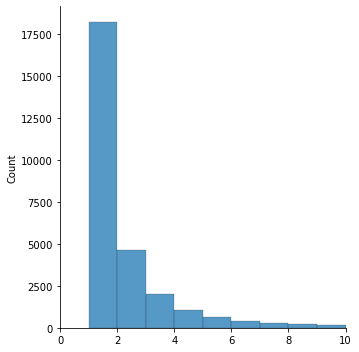

In [50]:
# On prendre seulement les entreprises avec au moins un articles associer
#sns.set(rc={'figure.figsize':(40,5)})
values = list(dict_count.values())
sns.displot(values, binwidth=1) #bins=20
plt.xlim(0, 10)

number = 5
print(stats.describe(values))
print ("There are",round(values.count(1)/len(values)*100,2), "% articles with one associated article")
under_n = [1 for i in values if i < number]
print ("There are",round(len(under_n)/len(values)*100,2), "% articles with less than",number,"associated article")

# Tokenize et suppression de stop words du corpus

In [51]:
#imports
import nltk
import re
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.corpus import stopwords
stop_words = stopwords.words('french')

In [52]:
print ("Number of stop words",len(stop_words ))
print ("Ex:",stop_words[:5])

Number of stop words 157
Ex: ['au', 'aux', 'avec', 'ce', 'ces']


In [14]:
corpus_cleaned = deepcopy(corpus_list)
for document in tqdm(corpus_cleaned):
    plain_text = document["corpus"]
    plain_text = plain_text.lower()
    plain_text= re.sub(r'\s+', ' ', plain_text)
    #plain_text = re.sub("[^a-z0-9]", ' ', plain_text)
    plain_text = re.sub("[^a-z]", ' ', plain_text)
    plain_text = re.sub(r'\s+', ' ', plain_text)
    #remove one letter words?
    #remove numbers?
    pt_words = word_tokenize(plain_text)
    cleaned_words =list()
    for word in pt_words:
        if len(word)>1:
            if word not in stop_words:
                cleaned_words.append(word)
    document["corpus"] = cleaned_words
# 100%|██████████| 57540/57540 [03:30<00:00, 273.74it/s]

100%|██████████| 57540/57540 [03:55<00:00, 244.24it/s]


# Tokenize en gardant que les Noms 

In [53]:
import stanfordnlp
#stanfordnlp.download('fr')   # This downloads the French models for the neural pipeline
#nlp = stanfordnlp.Pipeline(lang="fr",processors = "tokenize,mwt,lemma,pos") # This sets up a default neural pipeline in French
nlp = stanfordnlp.Pipeline(lang="fr",processors = "tokenize,pos")
#Documentation:
#https://www.analyticsvidhya.com/blog/2019/02/stanfordnlp-nlp-library-python/#

Use device: cpu
---
Loading: tokenize
With settings: 
{'model_path': '/Users/pierre/stanfordnlp_resources/fr_gsd_models/fr_gsd_tokenizer.pt', 'lang': 'fr', 'shorthand': 'fr_gsd', 'mode': 'predict'}
---
Loading: pos
With settings: 
{'model_path': '/Users/pierre/stanfordnlp_resources/fr_gsd_models/fr_gsd_tagger.pt', 'pretrain_path': '/Users/pierre/stanfordnlp_resources/fr_gsd_models/fr_gsd.pretrain.pt', 'lang': 'fr', 'shorthand': 'fr_gsd', 'mode': 'predict'}
Done loading processors!
---


In [54]:
#Exemple
doc = nlp("Les victoires de Joe Biden à la présidentielle américaine à peine proclamée par les principaux médias américains.")  
#extract_pos(doc)
for sent in doc.sentences:
    for word in sent.words:
        print(word.text,":", word.upos, word.pos)
doc.sentences[0].words[0] 

Les : DET _
victoires : NOUN _
de : ADP _
Joe : PROPN _
Biden : PROPN _
à : ADP _
la : DET _
présidentielle : ADJ _
américaine : ADJ _
à : ADP _
peine : NOUN _
proclamée : VERB _
par : ADP _
les : DET _
principaux : ADJ _
médias : NOUN _
américains : ADJ _
. : PUNCT _


<Word index=1;text=Les;upos=DET;xpos=_;feats=Definite=Def|Gender=Fem|Number=Plur|PronType=Art>

In [66]:
keep = ["NOUN","PROPN"]
#corpus_nouns = deepcopy(corpus_list)
#for document in tqdm(corpus_nouns):

for i in range(29805,len(corpus_nouns)):
    document = corpus_nouns[i]
    plain_text = document["corpus"]
    doc = nlp(plain_text)
    cleaned_words =list()
    for sent in doc.sentences:
        for word in sent.words:
            pos_tag = word.upos
            if pos_tag in keep:
                cleaned_words.append(word.text.lower())
    document["corpus"] = cleaned_words 
#20hours of computation to get.

In [74]:
len(corpus_nouns)

57538

In [67]:
# save corpus_nouns
PATH = "./data/ArticleCompany_2020-11-17/"
file = "corpus_nouns"
a_file = open(PATH + file + ".json", "w")
json.dump(corpus_nouns, a_file)
a_file.close()
print (file,"is saved successfully")

corpus_nouns is saved successfully


In [79]:
# load corpus_nouns 
PATH = "./data/ArticleCompany_2020-11-17/"
file = "corpus_nouns"
with open(PATH + file +".json") as json_file: 
    corpus_nouns = json.load(json_file) 

In [82]:
print ("The siren list is:",type(corpus_nouns[0]["siren"]), type(corpus_nouns[0]["corpus"]))

The siren list is: <class 'list'> <class 'list'>


# Extraction d'entreprise avec plus de n articles sur elles

In [83]:
print(list(dict_names.keys())[0:5])
print (dict_names['399258755'])
name_search = "APPLE FRANCE"
for siren, name in dict_names.items():  # for name, age in dictionary.iteritems():  (for Python 2.x)
    if name_search in name:
        print(siren, name)
print("APPLE FRANCE a",dict_count["322120916"],"articles dans le corpus")

['419838529', '813883964', '572060333', '542104245', '399258755']
SPIE OPERATIONS
322120916 APPLE FRANCE
APPLE FRANCE a 7 articles dans le corpus


In [84]:
number = 5 # Number of articles a company must have to be kept in the list
siren_filtered =[key for key in dict_count if dict_count[key] > number]
print ("There are",len(siren_filtered),"companies with MORE than",number,"associated articles")

There are 2084 companies with MORE than 5 associated articles


In [85]:
for key in siren_filtered:
    if len(key)>10:
        print (key)
#find out why label_dict

# Creation de Train et Test set pour l'entrainement de Tf.Idf

In [86]:
#from sklearn.model_selection import train_test_split
import random

In [87]:
# Remove all of the articles that dont talk about our selected companies (in siren filtered)
# Split corpus train/test
#corpus = corpus_cleaned
corpus = corpus_nouns
train_size = 0.7
X_train_corpus = list()
X_test_corpus = list()

#Removing unwanted articles
print("Removing unwanted articles")
corpus_temp = list()
for document in corpus:
    keep = False
    for document_sirens in document["siren"]:
        for sirens in siren_filtered:
            if document_sirens == sirens:
                keep = True
    if keep:
        corpus_temp.append(document)
print ("We removed:",len(corpus)-len(corpus_temp),"articles and we have",len(corpus_temp),"left")
corpus = corpus_temp
 
#Splitting data
print("Splitting data") 
for document in corpus:
    if (random.uniform(0, 1)<train_size):
        X_train_corpus.append(document)
    else:
        X_test_corpus.append(document)
print ("We have",len(X_train_corpus),"documents in the training corpus")
print ("We have",len(X_test_corpus),"documents in the testing corpus")

Removing unwanted articles
We removed: 29189 articles and we have 28349 left
Splitting data
We have 19846 documents in the training corpus
We have 8503 documents in the testing corpus


# Tf.Idf pour une liste d'entreprise sur le training data

In [89]:
# imports
from sklearn.feature_extraction.text import TfidfVectorizer 

In [90]:
# Tf.Idf on Companies that have Associated Articles 

relevant_words_tfidf = {}
corpus = X_train_corpus # corpus

list_siren = siren_filtered

def identity_tokenizer(text):
    return text
for siren in tqdm(list_siren):
    #siren = "322120916" #APPLE FRANCE
    plain_text_list = list()
    company_article = list()
    #binary = True
    #sublinear_tf=False
    tfidf_vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, ngram_range = (1,1), lowercase=False, sublinear_tf=True)
    for document in corpus:
        if siren in document["siren"]:
            company_article = company_article+document["corpus"]  # add article to company BIG article
        else:
            plain_text_list.append(document["corpus"]) # otherwise add to corpus

    plain_text_list.insert(0,company_article) # add company article to begging of corpus
    tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(plain_text_list)

    #Get the tf-idf scores for the words in the company article complication.
    first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0] # discard tf.idf scores for the other texts

    # place tf-idf values in a pandas data frame 
    df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"]) 
    df = df.sort_values(by=["tfidf"],ascending=False).head(40) # Take top 40 words

    relevant_words_tfidf[siren] = list(zip(list(df.index),list(df["tfidf"])))
    #print (relevant_words_tfidf[company])


#100%|██████████| 2084/2084 [2:19:42<00:00,  4.02s/it] # tokenized tf
#100%|██████████| 2084/2084 [2:03:31<00:00,  3.56s/it] # tokenized binary
#100%|██████████| 2084/2084 [1:50:00<00:00,  3.17s/it] # tokenized sublinear_tf
#100%|██████████| 2084/2084 [1:21:23<00:00,  2.34s/it] # nouns sublinear_tf


100%|██████████| 2084/2084 [1:21:23<00:00,  2.34s/it]


In [ ]:
relevant_words_tfidf

In [91]:
# save dictionary
PATH = "./relevant_words/francais/"
file = "relevant_words_tfidf_nouns_sublinear_tf"
a_file = open(PATH + file + ".json", "w")
json.dump(relevant_words_tfidf, a_file)
a_file.close()
print (file,"is saved successfully")

relevant_words_tfidf_nouns_sublinear_tf is saved successfully


In [92]:
# load dictionary 
PATH = "./relevant_words/francais/"
file = "relevant_words_tfidf_nouns_sublinear_tf"
a_file = open(PATH + file + ".json", "r")
relevant_words_tfidf = json.load(a_file)
#relevant_words_tfidf = dict(relevant_words_tfidf)
# check if well loaded
print (file,"is loaded successfully") 

relevant_words_tfidf_nouns_sublinear_tf is loaded successfully


In [18]:
#relevant_words_tfidf.keys()
#relevant_words_tfidf['419838529']
#type(relevant_words_tfidf)
#len(relevant_words_tfidf.keys())

# Fetching Relevant Words from ES

In [115]:
# load dictionary 
PATH = "./relevant_words/francais/"
file = "relevant_words_train"
a_file = open(PATH + file + ".json", "r")
relevant_words_es = json.load(a_file)
#relevant_words_tfidf = dict(relevant_words_tfidf)


# check if well loaded
print (file,"is loaded successfully") 

relevant_words_train is loaded successfully


# Building baseline model 

In [162]:
#Labeling article if it has the company name in it
relevant_words_baseline = dict()
for key in dict_names.keys():
    #print (key)
    #print([dict_names[key].lower()])
    relevant_words_baseline[key] = [[dict_names[key].lower(),1]]
#relevant_words_baseline

# Text Classifier

In [101]:
# imports
import operator

In [102]:
#################################################################
# CLEANING PLAIN TEXT
#Input  : Plain text - String
#Output : Text removing all punctuation and lowercased
#################################################################
def clean_plain_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub("[^a-z0-9]", ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

In [103]:
#################################################################
# Gives a companies "related score" wrt an article (using it's significant words)
#INPUT :plain_text- String/ word_list - list of significant words
#OUTPUT: Score the chances the company is related to the article
#################################################################
def score_company(plain_text, word_list): 
    epsilon = 0.0001
    avg_word_length =6+1 #+1 counting the spaces
    n_words = len(word_list)
    words_in_text = 0
    #print (word_list)
    for word in word_list:
        words_in_text +=plain_text.count(word)
    #return words_in_text
    return words_in_text/(len(plain_text)/avg_word_length + epsilon)

In [133]:
#################################################################
# For an Article, gives the "related scores" for all companies
#INPUT :plain_text- String/company related words - dict/ params
#OUTPUT: dict of companies and their "related scores"
#################################################################
def text_label_scores(plain_text,related_words,n_sig_words=10, min_score = 0.01):
    label_dict = {}
    #print (sig_words_list)
    for siren in related_words.keys():
        #print(related_words[siren])
        sig_words_list = np.array(related_words[siren])[:n_sig_words,0] # Build significant word list (with no scores)
        #print ("sig_words_list")
        score = score_company(plain_text, sig_words_list)
        #print (score)
        if score>=min_score:
            label_dict[siren]= score
    ### Soft_max ###
    #sum_exp = sum([np.exp(v) for v in label_dict.values()])
    #label_dict = {k: np.exp(v)/sum_exp for k, v in sorted(label_dict.items(), key=lambda item: -item[1])}
    ### normalizing score ###
    #max_val = max(label_dict.values())
    #label_dict = {k: v/max_val for k, v in sorted(label_dict.items(), key=lambda item: -item[1])}
    ### Plain score ###
    label_dict = {k: v for k, v in sorted(label_dict.items(), key=lambda item: -item[1])}
    return label_dict

In [134]:
# testing text_label_scores
plain_text = """
La victoire de Joe Biden à la présidentielle américaine à peine proclamée par les principaux 
médias américains, les messages de félicitations des dirigeants occidentaux affluent. Sur Twitter,
une courte séquence vidéo fait le buzz entre Londres et Dublin. Ce 7 novembre, on y voit le 
candidat démocrate entouré de journalistes.
"""
plain_text = clean_plain_text(plain_text)

related_words = relevant_words_tfidf
n_sig_words= 10
min_score = 0.1 # nbr of sig words in text
#print (plain_text)
label_dict = text_label_scores(plain_text,related_words, n_sig_words, min_score)
print(label_dict)
for key in label_dict.keys(): # Should not trigger
    if len(key)>10:
        print (key)
#find out why label_dict

{'504914094': 0.37421301273865115, '315127944': 0.35220048257755404, '533727111': 0.33018795241645693, '805170032': 0.33018795241645693, '790003032': 0.30817542225535977, '818435240': 0.30817542225535977, '502220056': 0.28616289209426266, '444180434': 0.28616289209426266, '304602956': 0.2421378317720684, '810146563': 0.2421378317720684, '334181708': 0.15408771112767988, '433925229': 0.15408771112767988, '413967159': 0.11006265080548563, '444465736': 0.11006265080548563, '433691862': 0.11006265080548563, '352973622': 0.11006265080548563}


# Function to return predicted text labels

In [135]:
#################################################################
# For an Article, predicts the labels (sirens)
#INPUT : plain_text- String/company related words - dict/ params
#OUTPUT: dict of companies and their "related scores"
#################################################################
def label_text(plain_text,related_words, n_sig_words= 10, min_score = 0.1):
    label_dict = text_label_scores(plain_text,related_words, n_sig_words, min_score)
    #print("best score",label_dict[list(label_dict.keys())[0]])
    sirens = list(label_dict.keys())
    return sirens[:8] # limiting the number of predictions to 8

# Testing accuracy of the model

In [170]:
# Convert the list in the sirens to actual list!

#related_words = relevant_words_tfidf #model related words
#related_words = relevant_words_es
related_words = relevant_words_baseline
corpus = X_train_corpus[:300] # pour verifier que on peut sur entrainer
#corpus = X_test_corpus[:300] # pour tester sur de nouveaux articles

pred_eval = list() # Tag each prediction 1:correct, 0:wrong for each article
pred_labels = list() # Siren predicted for each article
article_eval = list() # Tag each label if 1:predicted, 0:not predicted for each article
article_labels = list() # Siren labels for each article
pred_stats = list() #list all predicted sirens
label_stats = list() # iist of all siren labels
for document in tqdm(corpus):
    plain_text = document["corpus"]
    #pred_labels
    pred_siren = label_text(plain_text,related_words, n_sig_words= 10, min_score = 0.1)
    pred_labels.append(pred_siren)
    
    #pred_stats
    pred_stats += pred_siren
    
    #article_labels
    true_label =document["siren"]
    article_labels.append(true_label)
    
    #pred_eval
    is_labeled = [0]*len(pred_siren)
    for i in range(len(pred_siren)):  # For each prediction list tag the good and bad predictions
        for label in true_label:
            if pred_siren[i]==label:
                is_labeled[i]=1
    pred_eval.append(is_labeled) 
    
    #article_eval
    is_predicted = [0]*len(true_label)
    for i in range(len(true_label)):  # For each prediction list tag the good and bad predictions
        for pred in pred_siren:
            if true_label[i]==pred:
                is_predicted[i]=1
    article_eval.append(is_predicted) 

100%|██████████| 300/300 [01:15<00:00,  3.95it/s]


# EVALUATING MODEL

In [111]:
import matplotlib.pylab as plt

In [169]:
# How many times (at least) one of the companies are predicted
print ("There are",len(pred_eval),"texts evaluated")
acc1 = list()
for preds in pred_eval:
    acc1.append(any(preds))
print("Accuracy1:", np.sum(acc1)/len(pred_eval),"(with at least ONE label predicted)")

# How many times ALL the labels are present in the prediction. 
acc2 = list()
for i in range(len(pred_eval)):
    len_label = len(corpus[i]["siren"])
    n_correct_pred = np.sum(pred_eval[i])
    if len_label==n_correct_pred:
        acc2.append(True)
    else:
        acc2.append(False)
    if len(corpus[i]["siren"])<np.sum(pred_eval[i]): # Should never trigger
        print("Error to many good predictions")   
print("Accuracy2:", np.sum(acc2)/len(pred_eval),"(with ALL labels predicted)")

# How many times ALL the labels are present in the prediction and are . 
acc3 = list()
for i in range(len(pred_eval)):
    len_label = len(corpus[i]["siren"])
    n_first_correct_pred = np.sum(pred_eval[i][:len_label])# Keeping only the len_label first predictions
    if len_label==n_first_correct_pred:
        acc3.append(True)
    else:
        acc3.append(False)
    if len(corpus[i]["siren"])<np.sum(pred_eval[i]): # Should never trigger
        print("Error to many good predictions") 
print("Accuracy3:", np.sum(acc3)/len(pred_eval),"(with ALL labels predicted in the FIRST predictions)")

# How many predictions are wrong wrt. how many are right (TRUE, FALSE)
true_pred = 0
pred = 0
for preds in pred_eval:
    true_pred += np.sum(preds)
    pred += len(preds)
print("Accuracy4:",true_pred/pred,"(Number of correct predictions over total number of predictions overall)")

# Average number of predictions vs average number of labels
len_label = list()
len_pred = list()
for i in range(len(pred_eval)):
    len_label.append(len(corpus[i]["siren"]))
    len_pred.append(len(pred_eval[i]))
print("Average number of predictions",np.mean(len_pred),"vs average number of labels :", np.mean(len_label))

# Most commun labels predicted
count_pred = dict()
for siren in pred_stats:
    if siren in count_pred.keys():
        count_pred[siren] +=1
    else:
        count_pred[siren] = 1
key_max = list(filter(lambda t: t[1]==max(count_pred.values()), count_pred.items()))[0][0] 
print("The siren that is predicted the most is:",key_max,"(",np.max(list(count_pred.values())),"times)")
#sns.catplot(x="deck", kind="count", palette="ch:.25", data=pred_stats)

#Precision : Somme :a dans A ((Somme de L(a) correcte) /( Somme de L(a)))/ |A|
# True pos/(True Pos + False Pos) -> average for each siren
avg_sum = 0.0
for preds in pred_eval:
    if len(preds)>0:
        avg_sum += sum(preds)/len(preds)

print("Precision:", avg_sum/len(pred_eval),"AVG(L(a) correcte/Somme de L(a))")

#Rappel : pour chaque article (nombre de label correctes/Nombre de label vrai )
# True pos/(True Pos + False Neg) -> average for each siren
avg_sum = 0.0
for labels in article_eval:
    if len(labels)>0:
        avg_sum += sum(labels)/len(labels)
print("Rappel:",avg_sum/len(article_eval),"AVG((nombre de label correctes/Nombre de label vrai ))")

# Influence of the min_score/ n_sig_words on the prediction.

# Influence on the prediction protocol influence.


There are 300 texts evaluated
Accuracy1: 0.6566666666666666 (with at least ONE label predicted)
Accuracy2: 0.5866666666666667 (with ALL labels predicted)
Accuracy3: 0.5733333333333334 (with ALL labels predicted in the FIRST predictions)
Accuracy4: 0.6623376623376623 (Number of correct predictions over total number of predictions overall)
Average number of predictions 1.0266666666666666 vs average number of labels : 1.1433333333333333
The siren that is predicted the most is: 542107651 ( 96 times)
Precision: 0.5661111111111112 AVG(L(a) correcte/Somme de L(a))
Rappel: 0.621 AVG((nombre de label correctes/Nombre de label vrai ))


In [182]:
#Precision : Somme :a dans A ((Somme de L(a) correcte) /( Somme de L(a)))/ |A|
# True pos/(True Pos + False Pos) -> average for each siren
precision_list = list()
recall_list = list()
for siren in siren_filtered:
    true_pos = 0.0  # Siren is a label and is predicted
    false_pos = 0.0 # Siren is NOT a label and is predicted (false prediction)
    true_neg = 0.0  # Siren is NOT a label and is not predicted (don't care)
    false_neg = 0.0 # Siren is a label and is NOT predicted
    for i in range(len(article_eval)):
        for j in range(len(article_labels[i])):
            if siren==article_labels[i][j]:
                if article_eval[i][j]==1:
                    true_pos +=1
                else:
                    false_neg +=1
    for i in range(len(pred_eval)):
        for j in range(len(pred_labels[i])):
            if siren==pred_labels[i][j]:
                if pred_eval[i][j]==0:
                    false_pos += 1

    if siren in label_stats:
        precision = true_pos/(true_pos+false_pos)
        recall = true_pos/(true_pos+false_neg)
        precision_list.append(precision)
        recall_list.append(recall)

print("Precision:",precision_list,"True_pos/(True_Pos + False_Neg) -> average for each siren")

#Rappel : pour chaque article (nombre de label correctes/Nombre de label vrai )
# True pos/(True Pos + False Neg) -> average for each siren
print("Rappel:",recall_list,"True_pos/(True_Pos + False_Neg) -> average for each siren")


Precision: [] True_pos/(True_Pos + False_Neg) -> average for each siren
Rappel: [] True_pos/(True_Pos + False_Neg) -> average for each siren


In [165]:
model_eval[:10]


[[1, 0],
 [1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [0, 0, 0],
 [1, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0]]

In [166]:
article_eval[:10]

[[1, 1], [1], [0], [0], [1], [0], [1], [1], [1, 1], [1]]